# Import

In [20]:
import os
import pathlib
import tensorflow as tf
import IPython.display as display
from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import shutil

# Functions

In [42]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [80]:
# Gets the bounding box for only the breast, centered on the y axis
def get_boundary(img):
    idx = 0
    right = 0
    left = 224
    for x in img.numpy():
        for y in x:
            idx += 1
            if y[0] >= 50 and idx > right:
                right = idx        
        idx = 224
        for y in reversed(x):
            idx -= 1
            if y[0] >= 50 and idx < left:
                left = idx
        idx = 0

    # bounding box
    y_min = (img.shape[0]-(right-left))//2
    x_min = left
    y_max = img.shape[0]-y_min
    x_max = right
    # print(right, left)
    return x_min,y_min,x_max,y_max

In [81]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
def generate_images(data_dir, aug_directory, aug_type, aug_func, aug_params):
    sample_shown = False
    # Generates new augmented images
    if aug_type != 'plain':
        for class_name in CLASS_NAMES:
            # List all the images in the given directory (It should be Splitted_Data/Train/plain)
            images_path = list(data_dir.glob(class_name+'/*.png'))
            
            for image in images_path:
                try:
                    # Copy the images in the directory of the augmented img
                    img_name = str(image).split('/')[-1]
                    img = tf.io.read_file(str(image))
                    # Copy image to augmented directory
                    fname = tf.constant(aug_directory+'/'+aug_type+'/'+class_name+'/'+img_name)
                    fwrite = tf.io.write_file(fname, img)

                    img = tf.image.decode_png(img, channels=3)
                    if aug_type == 'crop':
                        x_min,y_min,x_max,y_max = get_boundary(img)
                        im = Image.open(str(image))
                        im = im.crop((x_min,y_min,x_max,y_max))
                        im = im.resize((224,224))
                        im.save(aug_directory+'/'+aug_type+'/'+class_name+'/'+aug_type+'_'+img_name, "PNG")
                        
                        # Show sample
                        if sample_shown == False:
                            sample_shown = True
                            display.display(im)
                    else:
                        aug_img = aug_func(img, *aug_params)
                        enc = tf.image.encode_png(aug_img)
                        fname = tf.constant(aug_directory+'/'+aug_type+'/'+class_name+'/'+aug_type+'_'+img_name)
                        fwrite = tf.io.write_file(fname, enc)

                        # Show sample
                        if sample_shown == False:
                            visualize(img, aug_img)
                            sample_shown = True

                except Exception as error:
                    print(error)
                    continue

# Create Directories

In [45]:
CLASS_NAMES = ['Density4Benign', 'Density1Benign', 'Density3Malignant', 'Density3Benign', 'Density4Malignant', 'Density2Benign', 'Density1Malignant', 'Density2Malignant']

augmentation_type = ['plain', 'crop', 'vertical_flip', 'horizontal_flip', 'brightness']

In [46]:
def create_class_dir(directory, aug_type):
    for class_name in CLASS_NAMES:
        try:
            os.mkdir(os.path.join('.',directory+'/'+aug_type+'/'+class_name))
            print(class_name," directory created")
        except FileExistsError as error:
            print(error)
            continue

In [37]:
def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

def train_val_split(path_to_data, path_to_train_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])
        path_to_save_train = os.path.join(path_to_train_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)

        if not os.path.exists(path_to_save_train):
            os.makedirs(path_to_save_train)

        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
        # moves data
        for j in range(int(data_counter_per_class[i]) - int(test_counter[i])):
            dst = os.path.join(path_to_save_train, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)

In [59]:
try:
    # Create Splitted Dataset directory
    path = os.path.join('.', 'Splitted_Dataset/')
    os.mkdir(path)
    print("Splitted_Dataset directory created")
except FileExistsError as error:
    print(error)
    
try:
    path = os.path.join('.', 'Splitted_Dataset/Train/')
    os.mkdir(path)
except FileExistsError as error:
    print(error)

try:
    path = os.path.join('.', 'Splitted_Dataset/Test/')
    os.mkdir(path)
except FileExistsError as error:
    print(error)

# Create Test subdirectories
for class_name in CLASS_NAMES:
    try:
        os.mkdir(os.path.join('.','Splitted_Dataset/Test/'+class_name))
        print(class_name,"Test directory created")
    except FileExistsError as error:
        print(error)
        continue

# Create subdirectories
for aug_type in augmentation_type:
    try:
        os.mkdir(os.path.join('.','Splitted_Dataset/Train/'+aug_type))
        print(aug_type," directory created")
        create_class_dir('Splitted_Dataset/Train/', aug_type)
    except FileExistsError as error:
        print(error)
        create_class_dir('Splitted_Dataset/Train/', aug_type)
        continue


[Errno 17] File exists: './Splitted_Dataset/'
[Errno 17] File exists: './Splitted_Dataset/Train/'
[Errno 17] File exists: './Splitted_Dataset/Test/'
[Errno 17] File exists: './Splitted_Dataset/Test/Density4Benign'
[Errno 17] File exists: './Splitted_Dataset/Test/Density1Benign'
[Errno 17] File exists: './Splitted_Dataset/Test/Density3Malignant'
[Errno 17] File exists: './Splitted_Dataset/Test/Density3Benign'
[Errno 17] File exists: './Splitted_Dataset/Test/Density4Malignant'
[Errno 17] File exists: './Splitted_Dataset/Test/Density2Benign'
[Errno 17] File exists: './Splitted_Dataset/Test/Density1Malignant'
[Errno 17] File exists: './Splitted_Dataset/Test/Density2Malignant'
[Errno 17] File exists: './Splitted_Dataset/Train/plain'
[Errno 17] File exists: './Splitted_Dataset/Train//plain/Density4Benign'
[Errno 17] File exists: './Splitted_Dataset/Train//plain/Density1Benign'
[Errno 17] File exists: './Splitted_Dataset/Train//plain/Density3Malignant'
[Errno 17] File exists: './Splitted_Data

In [61]:
original_data_dir = './Dataset'
train_dir = 'Splitted_Dataset/Train/'
plain_train_dir = 'Splitted_Dataset/Train/plain/'
test_dir = 'Splitted_Dataset/Test/'
data_dir = pathlib.Path(plain_train_dir)

# Split the DataSet in 80% train 20% test

In [57]:
train_val_split(original_data_dir, plain_train_dir, test_dir, 0.8)

In [6]:
# input_folder = "./Dataset"
# output = "./Splitted_Dataset" #where you want the split datasets saved. one will be created if none is set

# splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

# Generate and save vertical flip images

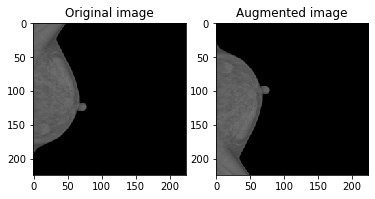

In [62]:
generate_images(data_dir, train_dir, 'vertical_flip', tf.image.flip_up_down, [])

# Generate and save horizontal flip images

In [10]:
generate_images(data_dir, train_dir, 'horizontal_flip', tf.image.flip_left_right, [])

horizontal_flip


# Brightness

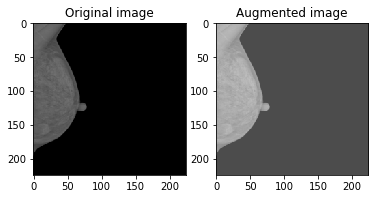

In [64]:
generate_images(data_dir, train_dir, 'brightness', tf.image.adjust_brightness, [+0.3])

# Breast centered crop

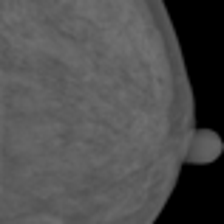

In [83]:
generate_images(data_dir, train_dir, 'crop', tf.image.crop_to_bounding_box, [])